Условие:
Построение ассоциативных правил для датасета https://www.kaggle.com/datasets/gorkhachatryan01/purchase-behaviour?select=dataset.csv

In [38]:
# Ksenia
# 18/02/24
# v.01

In [39]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import re
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx

In [40]:
data = pd.read_csv('dataset.csv', sep = ',', encoding= 'unicode_escape')

In [41]:
pd.set_option('display.max_colwidth', None)

In [42]:
data

,pork,sandwich bags,lunch meat,all- purpose,flour,soda,butter,vegetables,beef,aluminum foil,all- purpose.1,dinner rolls,shampoo,all- purpose.2
0,shampoo,hand soap,waffles,vegetables,cheeses,mixes,milk,sandwich bags,laundry detergent,dishwashing liquid/detergent,waffles,individual meals,hand soap,vegetables
1,pork,soap,ice cream,toilet paper,dinner rolls,hand soap,spaghetti sauce,milk,ketchup,sandwich loaves,poultry,toilet paper,ice cream,ketchup
2,juice,lunch meat,soda,toilet paper,all- purpose,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,pasta,tortillas,mixes,hand soap,toilet paper,vegetables,vegetables,paper towels,vegetables,flour,vegetables,pork,poultry,eggs
4,toilet paper,eggs,toilet paper,vegetables,bagels,dishwashing liquid/detergent,cereals,paper towels,laundry detergent,butter,cereals,bagels,paper towels,shampoo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493,beef,sandwich bags,hand soap,paper towels,paper towels,all- purpose,beef,fruits,coffee/tea,beef,shampoo,mixes,cheeses,juice
1494,dinner rolls,lunch meat,spaghetti sauce,pasta,vegetables,cereals,dinner rolls,soap,milk,eggs,poultry,cheeses,cereals,mixes
1495,lunch meat,eggs,poultry,vegetables,tortillas,beef,beef,individual meals,dishwashing liquid/detergent,shampoo,dishwashing liquid/detergent,dishwashing liquid/detergent,hand soap,sugar
1496,ketchup,milk,poultry,cheeses,soap,toilet paper,yogurt,beef,waffles,sugar,spaghetti sauce,all- purpose,sandwich bags,toilet paper


1. Подготовка данных и обработка пропусков

In [43]:
# Удаление ведущих пробелов из названий столбцов
data.columns = data.columns.str.strip()

In [44]:
# Проверка наличия Nan
data.isnull().sum()

pork                0
sandwich bags       0
lunch meat          0
all- purpose        0
flour               0
soda               51
butter             88
vegetables        143
beef              199
aluminum foil     258
all- purpose.1    296
dinner rolls      343
shampoo           396
all- purpose.2    455
dtype: int64

In [45]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1498 entries, 0 to 1497
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   pork            1498 non-null   object
 1   sandwich bags   1498 non-null   object
 2   lunch meat      1498 non-null   object
 3   all- purpose    1498 non-null   object
 4   flour           1498 non-null   object
 5   soda            1447 non-null   object
 6   butter          1410 non-null   object
 7   vegetables      1355 non-null   object
 8   beef            1299 non-null   object
 9   aluminum foil   1240 non-null   object
 10  all- purpose.1  1202 non-null   object
 11  dinner rolls    1155 non-null   object
 12  shampoo         1102 non-null   object
 13  all- purpose.2  1043 non-null   object
dtypes: object(14)
memory usage: 164.0+ KB


In [46]:
# Заполнение пропущенных значений в категориальных переменных модой
categorical_columns = data.select_dtypes(include=['object']).columns
data[categorical_columns] = data[categorical_columns].fillna(data[categorical_columns].mode().iloc[0])

# Вывод информации о пропущенных значениях после обработки
print(data.isnull().sum())

pork              0
sandwich bags     0
lunch meat        0
all- purpose      0
flour             0
soda              0
butter            0
vegetables        0
beef              0
aluminum foil     0
all- purpose.1    0
dinner rolls      0
shampoo           0
all- purpose.2    0
dtype: int64


In [47]:
data.nunique()

pork              38
sandwich bags     38
lunch meat        38
all- purpose      38
flour             39
soda              39
butter            39
vegetables        39
beef              39
aluminum foil     39
all- purpose.1    39
dinner rolls      39
shampoo           39
all- purpose.2    39
dtype: int64

### 2. Группировка по транзакциям
с помощью TransactionEncoder кодируем транзакции в формат, подходящий для функции Apriori.

In [48]:
# Преобразование данных в список списков
transactions = data.values.tolist()

# Преобразование списка списков в формат, подходящий для TransactionEncoder
encoder = TransactionEncoder()
encoder_n = encoder.fit(transactions).transform(transactions)

# Создание датафрейма из разреженной матрицы
transaction_matrix = pd.DataFrame(encoder_n, columns=encoder.columns_)

# Вывод матрицы транзакций
print(transaction_matrix)
display(transaction_matrix.head())

              all- purpose   aluminum foil   bagels   beef   butter   cereals  \
0     False          False           False    False  False    False     False   
1     False          False           False    False  False    False     False   
2      True           True           False    False  False    False     False   
3     False          False           False    False  False    False     False   
4     False          False           False     True  False     True      True   
...     ...            ...             ...      ...    ...      ...       ...   
1493  False           True           False    False   True    False     False   
1494  False          False           False    False  False    False      True   
1495  False          False           False    False   True    False     False   
1496  False           True           False    False   True    False     False   
1497   True          False           False    False  False    False     False   

       cheeses   coffee/tea

,,all- purpose,aluminum foil,bagels,beef,butter,cereals,cheeses,coffee/tea,dinner rolls,...,shampoo,soap,soda,spaghetti sauce,sugar,toilet paper,tortillas,vegetables,waffles,yogurt
0,False,False,False,False,False,False,False,True,False,False,...,True,False,False,False,False,False,False,True,True,False
1,False,False,False,False,False,False,False,False,False,True,...,False,True,False,True,False,True,False,False,False,False
2,True,True,False,False,False,False,False,False,False,False,...,False,False,True,False,False,True,False,True,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,True,True,False,False
4,False,False,False,True,False,True,True,False,False,False,...,True,False,False,False,False,True,False,True,False,False


In [49]:
print(transaction_matrix.shape)

(1498, 39)


## Алгоритм Apriori и правила ассоциаций

In [50]:
print(3/len(data))

0.0020026702269692926


In [51]:
# Применение алгоритма Apriori к данным
frequent_itemsets = fpgrowth(transaction_matrix, min_support=3/len(data), use_colnames=True)

# Создание ассоциативных правил
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=2.0)

# Вывод полученных правил
display(rules.head(20))
print("Rules identified: ", len(rules))

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,"( mixes, , poultry)","( vegetables, waffles)",0.007343,0.195594,0.003338,0.454545,2.323922,0.001902,1.474744,0.573907
1,"( vegetables, waffles)","( mixes, , poultry)",0.195594,0.007343,0.003338,0.017065,2.323922,0.001902,1.009891,0.708216
2,"( individual meals, waffles, mixes)",( bagels),0.016021,0.278371,0.009346,0.583333,2.095524,0.004886,1.731909,0.531305
3,( bagels),"( individual meals, waffles, mixes)",0.278371,0.016021,0.009346,0.033573,2.095524,0.004886,1.018162,0.724461
4,"( individual meals, vegetables, waffles, mixes)",( bagels),0.008678,0.278371,0.005340,0.615385,2.210662,0.002925,1.876235,0.552441
5,( bagels),"( individual meals, vegetables, waffles, mixes)",0.278371,0.008678,0.005340,0.019185,2.210662,0.002925,1.010712,0.758904
6,"( mixes, individual meals, waffles, poultry)",( bagels),0.004673,0.278371,0.003338,0.714286,2.565947,0.002037,2.525701,0.613146
7,"( individual meals, waffles, poultry)","( bagels, mixes)",0.018024,0.085447,0.003338,0.185185,2.167245,0.001798,1.122406,0.548470
8,"( individual meals, waffles, mixes)","( bagels, poultry)",0.016021,0.075434,0.003338,0.208333,2.761799,0.002129,1.167873,0.648304
9,"( mixes, individual meals, poultry)","( waffles, bagels)",0.021362,0.076769,0.003338,0.156250,2.035326,0.001698,1.094200,0.519782


Rules identified:  684792


In [52]:
# Вывод правил с наибольшим lift
top_lift_rules = rules.sort_values(by='lift', ascending=False).head(20)
print("Top 20 rules with highest lift:")
display(top_lift_rules)

# Вывод правил с наибольшим confidence
top_confidence_rules = rules.sort_values(by='confidence', ascending=False).head(20)
print("\nTop 20 rules with highest confidence:")
display(top_confidence_rules)

# Вывод правил с наибольшим support
top_support_rules = rules.sort_values(by='support', ascending=False).head(20)
print("\nTop 20 rules with highest support:")
display(top_support_rules)



Top 20 rules with highest lift:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
94945,"( individual meals, soap, pasta, cereals)","( pork, milk, shampoo, dishwashing liquid/detergent)",0.004005,0.004005,0.00267,0.666667,166.444444,0.002654,2.987984,0.997989
94960,"( pork, milk, shampoo, dishwashing liquid/detergent)","( individual meals, soap, pasta, cereals)",0.004005,0.004005,0.00267,0.666667,166.444444,0.002654,2.987984,0.997989
94929,"( pork, individual meals, pasta, cereals)","( milk, soap, shampoo, dishwashing liquid/detergent)",0.003338,0.006008,0.00267,0.800000,133.155556,0.002650,4.969960,0.995814
94976,"( milk, soap, shampoo, dishwashing liquid/detergent)","( pork, individual meals, pasta, cereals)",0.006008,0.003338,0.00267,0.444444,133.155556,0.002650,1.793992,0.998489
94963,"( pork, milk, soap, pasta)","( individual meals, shampoo, dishwashing liquid/detergent, cereals)",0.004005,0.005340,0.00267,0.666667,124.833333,0.002649,2.983979,0.995979
94942,"( individual meals, shampoo, dishwashing liquid/detergent, cereals)","( pork, milk, soap, pasta)",0.005340,0.004005,0.00267,0.500000,124.833333,0.002649,1.991989,0.997315
94965,"( pork, soap, pasta, cereals)","( individual meals, milk, shampoo, dishwashing liquid/detergent)",0.004673,0.004673,0.00267,0.571429,122.285714,0.002648,2.322430,0.996479
94940,"( individual meals, milk, shampoo, dishwashing liquid/detergent)","( pork, soap, pasta, cereals)",0.004673,0.004673,0.00267,0.571429,122.285714,0.002648,2.322430,0.996479
94933,"( pasta, individual meals, soap, shampoo)","( pork, milk, dishwashing liquid/detergent, cereals)",0.007343,0.003338,0.00267,0.363636,108.945455,0.002646,1.566183,0.998151
94972,"( pork, milk, dishwashing liquid/detergent, cereals)","( pasta, individual meals, soap, shampoo)",0.003338,0.007343,0.00267,0.800000,108.945455,0.002646,4.963284,0.994139



Top 20 rules with highest confidence:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
472236,"( all- purpose, juice, aluminum foil, cheeses, dishwashing liquid/detergent)",( poultry),0.002670,0.287717,0.002670,1.0,3.475638,0.001902,inf,0.714190
515501,"( individual meals, laundry detergent, butter, flour, dinner rolls)",( aluminum foil),0.002670,0.263685,0.002670,1.0,3.792405,0.001966,inf,0.738286
320945,"( juice, vegetables, laundry detergent, butter, ice cream)",( ketchup),0.002670,0.250334,0.002670,1.0,3.994667,0.002002,inf,0.751673
235893,"( vegetables, eggs, dinner rolls, cheeses, cereals)",( mixes),0.002670,0.273698,0.002670,1.0,3.653659,0.001939,inf,0.728246
320944,"( juice, vegetables, ketchup, butter, ice cream)",( laundry detergent),0.002670,0.264352,0.002670,1.0,3.782828,0.001964,inf,0.737617
320942,"( juice, vegetables, ketchup, laundry detergent, butter)",( ice cream),0.002670,0.275033,0.002670,1.0,3.635922,0.001936,inf,0.726908
212269,"( hand soap, sandwich loaves, pasta, fruits, beef)",( waffles),0.002670,0.279039,0.002670,1.0,3.583732,0.001925,inf,0.722892
262659,"( vegetables, yogurt, flour, dinner rolls, cheeses, spaghetti sauce)",( pasta),0.002670,0.271696,0.002670,1.0,3.680590,0.001945,inf,0.730254
515502,"( individual meals, aluminum foil, butter, flour, dinner rolls)",( laundry detergent),0.002670,0.264352,0.002670,1.0,3.782828,0.001964,inf,0.737617
94148,"( pork, shampoo, soap, milk, dishwashing liquid/detergent)","( pasta, cereals)",0.002670,0.072096,0.002670,1.0,13.870370,0.002478,inf,0.930388



Top 20 rules with highest support:


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
455057,"( coffee/tea, eggs, bagels)",( all- purpose),0.024700,0.263017,0.013351,0.540541,2.055152,0.006855,1.604021,0.526420
455059,"( coffee/tea, all- purpose)","( eggs, bagels)",0.066088,0.080107,0.013351,0.202020,2.521886,0.008057,1.152778,0.646176
455061,"( all- purpose, eggs)","( coffee/tea, bagels)",0.071429,0.077437,0.013351,0.186916,2.413793,0.007820,1.134647,0.630769
455062,"( eggs, bagels)","( coffee/tea, all- purpose)",0.080107,0.066088,0.013351,0.166667,2.521886,0.008057,1.120694,0.656023
455058,"( coffee/tea, eggs)","( all- purpose, bagels)",0.070093,0.075434,0.013351,0.190476,2.525074,0.008064,1.142111,0.649497
455056,"( coffee/tea, eggs, all- purpose)",( bagels),0.022697,0.278371,0.013351,0.588235,2.113133,0.007033,1.752527,0.539003
455065,( bagels),"( coffee/tea, eggs, all- purpose)",0.278371,0.022697,0.013351,0.047962,2.113133,0.007033,1.026537,0.729972
455064,( all- purpose),"( coffee/tea, eggs, bagels)",0.263017,0.024700,0.013351,0.050761,2.055152,0.006855,1.027456,0.696649
455060,"( coffee/tea, bagels)","( all- purpose, eggs)",0.077437,0.071429,0.013351,0.172414,2.413793,0.007820,1.122024,0.634877
455063,"( all- purpose, bagels)","( coffee/tea, eggs)",0.075434,0.070093,0.013351,0.176991,2.525074,0.008064,1.129886,0.653249


In [53]:
rules_df = rules.copy()

<>:24: DeprecationWarning: invalid escape sequence '\d'
<>:24: DeprecationWarning: invalid escape sequence '\d'
C:\Users\user\AppData\Local\Temp\ipykernel_9808\2633165278.py:24: DeprecationWarning: invalid escape sequence '\d'
  if re.compile("^[R]\d+$").fullmatch(node) != None:


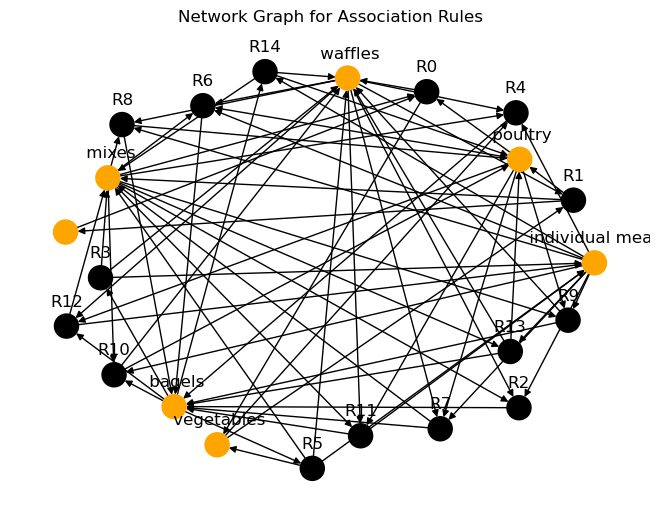

In [54]:
def draw_network(rules, rules_to_show):
  # Ориентированный граф от NetworkX
  network = nx.DiGraph()
  
  # Перебор количества правил для отображения
  for i in range(rules_to_show):
    
    # Добавление узла правила
    network.add_nodes_from(["R"+str(i)])
    for antecedents in rules.iloc[i]['antecedents']: 
        # Добавление узла-предшественника и ссылки на правило
        network.add_nodes_from([antecedents])
        network.add_edge(antecedents, "R"+str(i),  weight = 2)
      
    for consequents in rules.iloc[i]['consequents']:
        # Добавление узла-последователя и ссылки на правило
        network.add_nodes_from([consequents])
        network.add_edge("R"+str(i), consequents,  weight = 2)

  color_map=[]  
  
  # Для каждого узла, если это правило, цвет черный, в противном случае - оранжевый.
  for node in network:
       if re.compile("^[R]\d+$").fullmatch(node) != None:
            color_map.append('black')
       else:
            color_map.append('orange')
  
  # Расположение узлов с помощью spring layout
  pos = nx.spring_layout(network, k=16, scale=1)
  # Построение сетевого графа
  nx.draw(network, pos, node_color = color_map, font_size=8)            
  
  # Сдвиг расположения текста вверх
  for p in pos:  
      pos[p][1] += 0.12

  nx.draw_networkx_labels(network, pos)
  plt.title("Network Graph for Association Rules")
  plt.show()

draw_network(rules, 15)

## Вывод:
-- Для совместных покупок частая комбинация товаров составила "individual meals, soap, pasta, cereals" и "pork, milk, shampoo, dishwashing liquid/detergent". 
Многие из правил имеют очень высокие значения лифта, что свидетельствует о сильной взаимосвязи между товарами. Показывает, что эти товары часто покупают вместе и вероятность такой совместной покупки значительно выше, чем случайно.

-- Высокое доверие: Некоторые комбинации товаров имеют очень высокие показатели доверия, достигающие 1.0, что означает, что если покупатель приобретает один товар из антецедента, то с очень высокой вероятностью он купит и все товары из консеквента. Например, если клиент покупает ( all- purpose, juice, aluminum foil, cheeses, dishwashing liquid/detergent), то с большой вероятностью он также купит (poultry).

-- По уровню поддержки: часто покупка (coffee/tea, eggs, bagels) сопровождается покупкой (all- purpose)

-- Из этого следует, что для покупателей было бы идеальным, чтобы секция с бытовыми товарами (средствами бытовой химии, косметикой и тд) располагалась рядом с мясными товарами и крупами. 
Также использовать акции/скидки на комбинации товаров, которые часто берут. 